# Spatio-Temporal Variogram (Daily)

### Clean the data

First, load library and set encoding

In [39]:
library(ggplot2)
library(sqldf)
library(dplyr)
library(sp)
library(spacetime)
Sys.setlocale("LC_CTYPE", "thai")
options(encoding="UTF-8")

[1] "Thai_Thailand.874"

Set working directory (if needed)

In [40]:
#setwd("C:\\Users\\garavig\\Documents\\Haze\\HazeAnalysis\\Data")

Load and update sensorlist id to the newest. เบอร์ของเก่าปีที่แล้วมันผิด มี 0 เยอะเกิน ต้องแก้ไขก่อน

In [41]:
sensorlist<-read.csv("https://raw.githubusercontent.com/Maplub/MonthlyAirQuality/master/sensorlist.csv",stringsAsFactors = FALSE)
sensorlist[sensorlist$sensorid=="CU-S00054",1]<-"CU-S0054"
sensorlist[sensorlist$sensorid=="CU-S00083",1]<-"CU-S0083"
sensorlist[sensorlist$sensorid=="CU-S00103",1]<-"CU-S0103"
sensorlist[sensorlist$sensorid=="CU-S00104",1]<-"CU-S0104"
sensorlist$sensorid <- as.factor(sensorlist$sensorid)

Load daily data

In [42]:
daily<-read.csv("https://raw.githubusercontent.com/Maplub/AirQualityData/master/PM2-5_2018_Daily.csv")

In [43]:
colnames(daily)<-c('sensorid','date','pm25')
head(daily)

sensorid,date,pm25
CU-S0001,28-02-2018,52.52500
CU-S0002,15-02-2018,62.89826
CU-S0002,16-02-2018,50.96376
CU-S0002,17-02-2018,77.15833
CU-S0002,18-02-2018,79.91827
CU-S0002,19-02-2018,72.95452


In [44]:
daily[daily$sensorid=="CU-SOO94",1]<-"CU-S0094"

In [73]:
sqldf("select sensorid,count(pm25),min(date),max(date) from daily group by sensorid")

sensorid,count(pm25),min(date),max(date)
CU-S0001,1,28-02-2018,28-02-2018
CU-S0002,97,01-03-2018,31-05-2018
CU-S0003,108,01-03-2018,31-05-2018
CU-S0004,87,01-03-2018,31-03-2018
CU-S0005,99,01-03-2018,31-05-2018
CU-S0006,102,01-03-2018,31-05-2018
CU-S0007,1,28-02-2018,28-02-2018
CU-S0008,106,01-03-2018,31-05-2018
CU-S0009,54,01-06-2018,31-05-2018
CU-S0010,84,01-03-2018,31-05-2018


Update time to POSIXct

In [46]:
daily$timepos <- as.POSIXct(strptime(daily$date, "%d-%m-%Y"))

Select only one month, then order it by timepos and sensorid respectively.

In [74]:
newdaily<-daily[daily$timepos>="2018-03-01" & daily$timepos<="2018-03-31",]
newdaily<- newdaily[order(newdaily$timepos, newdaily$sensorid),]

### Deal with missing values

Create full date daily with distinct sensor id from newhour

In [75]:
datefull<-seq(from=min(newdaily$timepos),to=max(newdaily$timepos), by="day")

In [76]:
sensor_newdaily<-sqldf('select distinct(sensorid) from newdaily')

merge data to get every sensor with full datetime

In [77]:
fulldata<-merge(sensor_newdaily,datefull)
colnames(fulldata)[2]<-'timepos'

merge full data with raw data. leave null values จะได้ข้อมูลที่เว้นว่างวันที่ไม่มีข้อมูล

In [78]:
newdaily<-sqldf('select f.sensorid,f.timepos,n.pm25 from fulldata f LEFT JOIN newdaily n ON f.sensorid = n.sensorid AND f.timepos=n.timepos')

plot the data

Warning message:
"Removed 413 rows containing missing values (geom_path)."

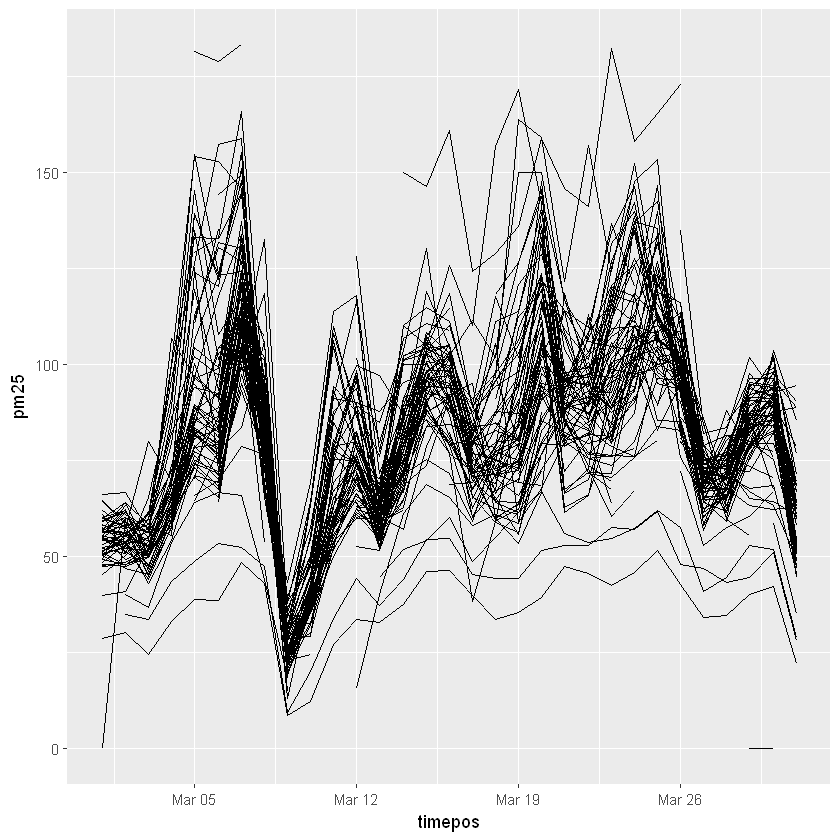

In [79]:
ggplot(data=newdaily, aes(x=timepos, y=pm25, group=sensorid)) + geom_line()

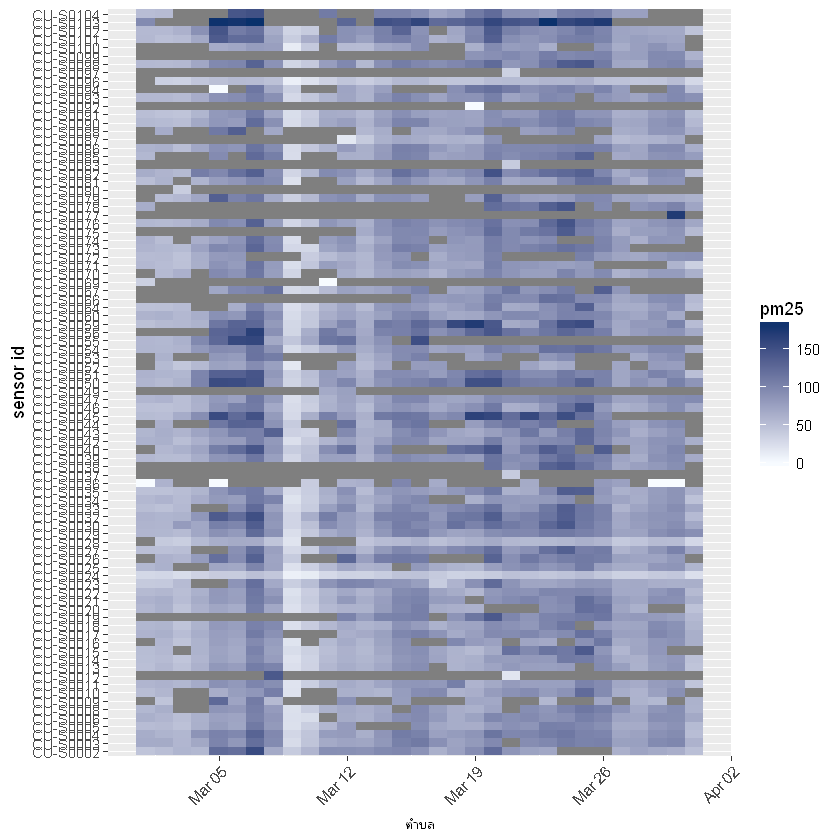

In [81]:
library(RColorBrewer)
colorsetting=brewer.pal(9,"Blues")
ggplot(newdaily, aes(y=sensorid,x=timepos)) +geom_tile(aes(fill = pm25))+ scale_fill_gradient(low=colorsetting[1],high=colorsetting[9])+labs(y = "sensor id",x="ตำบล")+theme(axis.text.x = element_text(angle = 45, hjust = 1))

Count number of NA per id to check the completeness of data. เช็คว่าข้อมูลทุก sensor ว่ามี missing data ไปเท่าไหร่

In [82]:
count_na<-aggregate(pm25 ~ sensorid, data=newdaily, function(x) {sum(is.na(x))}, na.action = NULL)
sensorFull<-count_na$sensorid[which(count_na$pm25<10)]
sensorFull

[1] CU-S0002 CU-S0003 CU-S0004 CU-S0005 CU-S0006 CU-S0008 CU-S0010 CU-S0011
 [9] CU-S0013 CU-S0014 CU-S0015 CU-S0016 CU-S0017 CU-S0018 CU-S0020 CU-S0021
[17] CU-S0022 CU-S0023 CU-S0024 CU-S0025 CU-S0026 CU-S0027 CU-S0028 CU-S0029
[25] CU-S0030 CU-S0032 CU-S0033 CU-S0034 CU-S0035 CU-S0039 CU-S0040 CU-S0042
[33] CU-S0043 CU-S0045 CU-S0046 CU-S0047 CU-S0050 CU-S0051 CU-S0054 CU-S0056
[41] CU-S0059 CU-S0060 CU-S0064 CU-S0070 CU-S0071 CU-S0072 CU-S0073 CU-S0074
[49] CU-S0076 CU-S0079 CU-S0081 CU-S0082 CU-S0085 CU-S0086 CU-S0090 CU-S0091
[57] CU-S0093 CU-S0096 CU-S0098 CU-S0101 CU-S0102
94 Levels: CU-S0001 CU-S0002 CU-S0003 CU-S0004 CU-S0005 CU-S0006 ... CU-SOO94

Select only sensors that has less than X missing values

In [83]:
newdaily<-subset(newdaily,sensorid %in% sensorFull)

Check whether there is a weird value in the data.

In [84]:
sqldf("select sensorid, min(pm25), max(pm25), avg(pm25) from newdaily group by sensorid")

sensorid,min(pm25),max(pm25),avg(pm25)
CU-S0002,39.378906,155.14764,79.25746
CU-S0003,25.620236,120.51272,82.70703
CU-S0004,29.940997,130.66093,85.02764
CU-S0005,22.079181,109.92901,73.15182
CU-S0006,23.018750,104.48407,75.85744
CU-S0008,22.079080,112.41551,75.88730
CU-S0010,20.240833,123.57595,75.55803
CU-S0011,19.206788,105.37050,72.29801
CU-S0013,22.326290,107.23838,69.49740
CU-S0014,19.901792,110.25898,69.17784


### Input into the model

The model use 3 inputs:
1. Unique datetime list in order (วันที่แบบเรียงลำดับ)
2. Unique sensorid in order (id แบบ เรียงลำดับ)
3. Sensor data order by sensorid and time respectively (ข้อมูลเรียงลำดับตาม id กับ เวลา เพื่อให้เชื่อมกับ 1 กับ 2)

In [89]:
datetime<-sqldf('select distinct(timepos) from newdaily')
datetime<-as.data.frame(datetime[order(datetime$timepos),])
colnames(datetime)<-c("timepos")
sensorid<-subset(sensorlist,sensorid %in% sensorFull)
sensorid <- as.data.frame(sensorid[order(sensorid$sensorid),])
row.names(sensorid) = sensorid$sensorid

In [59]:
#write.csv(sensorid,file="sensorid.csv")
#write.csv(newdaily,file="newhour.csv")

Create a SpatialPointsDataFrame

In [90]:
coordinates(sensorid)=~lon+lat
proj4string(sensorid)=CRS("+init=epsg:4326")

In [91]:
sensoridSP <- SpatialPoints(sensorid@coords,CRS("+init=epsg:4326")) 

Project lat/lon to UTM Zone 47

In [92]:
library(rgdal)
sensoridSP.UTM <- spTransform(sensoridSP, CRS("+init=epsg:32647"))

Warning message in title(...):
""zcol" is not a graphical parameter"

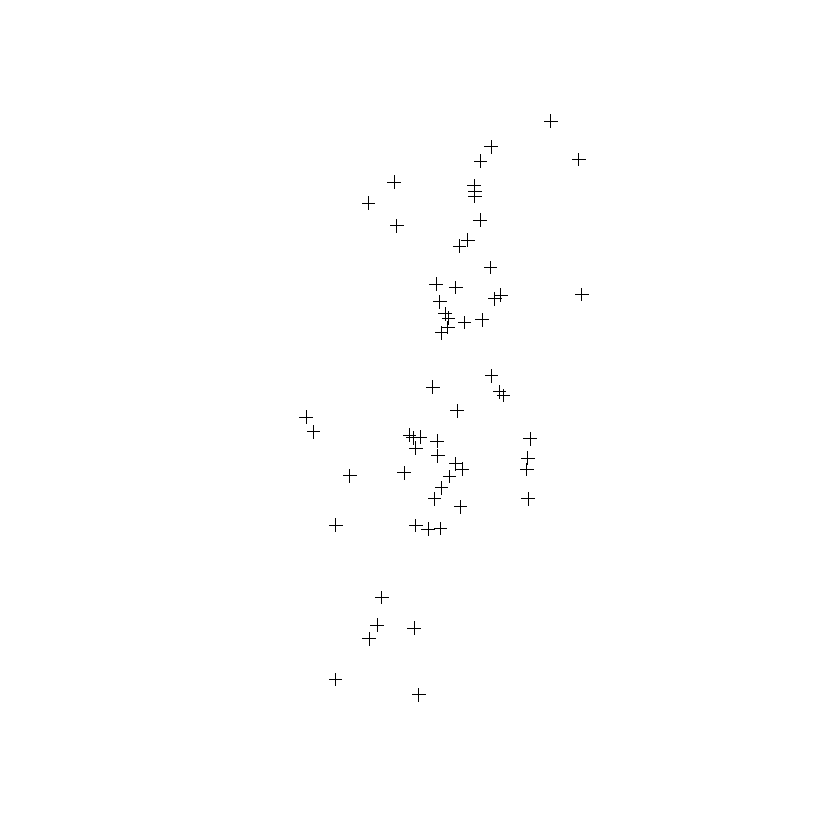

In [93]:
plot(sensoridSP.UTM,zcol="sensorid")

Create spatio-temporal using STFDF function from spacetime library
STFDF ข้อมูลจะแหว่งไม่ได้เลย

In [94]:
stdata<-STFDF(sensoridSP.UTM,datetime$timepos,data.frame(PM2.5=as.vector(newdaily$pm25)),delta(datetime$timepos))

Then plot it

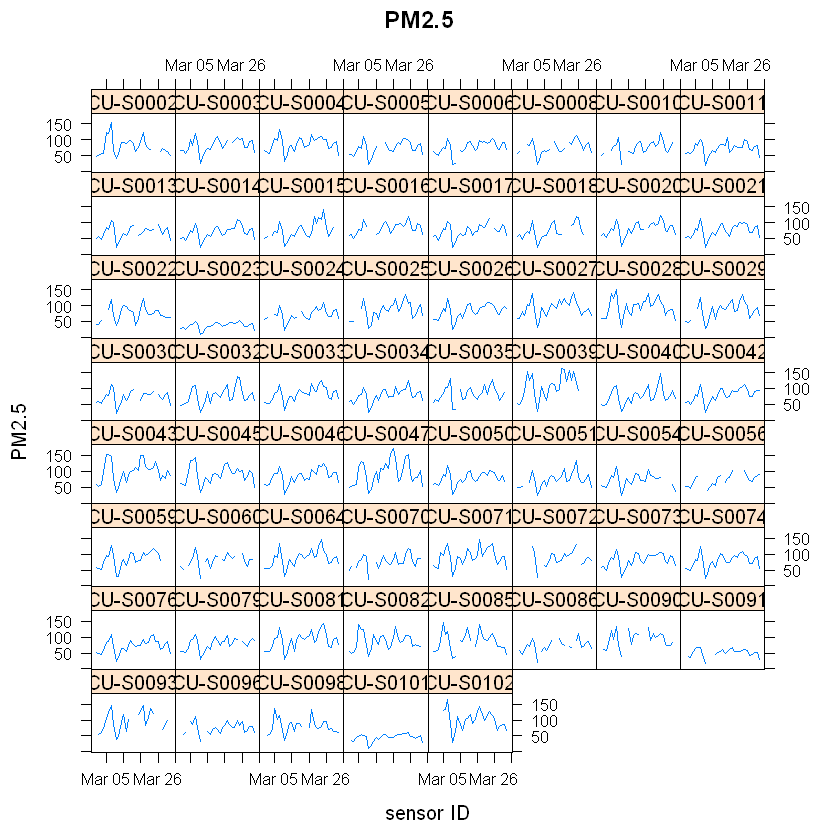

In [95]:
library(RColorBrewer)
colorsetting=brewer.pal(9,"Blues")

scales <- list(x = list(rot = 45))
stplot(stdata,mode="tp",cuts=9,scales=scales,xlab="sensor ID",col.regions = colorsetting)

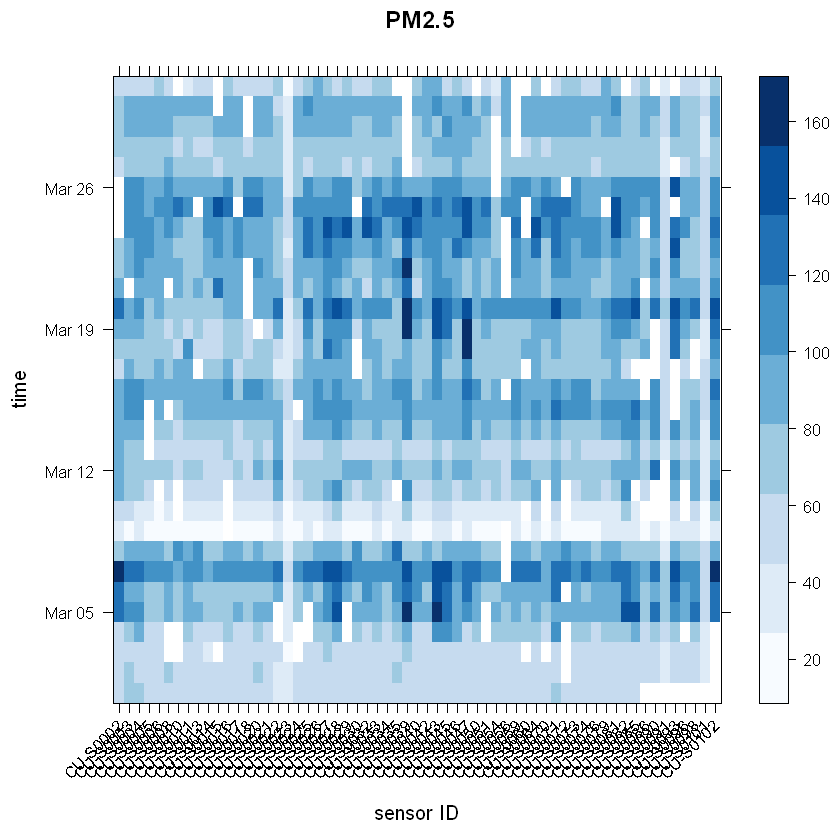

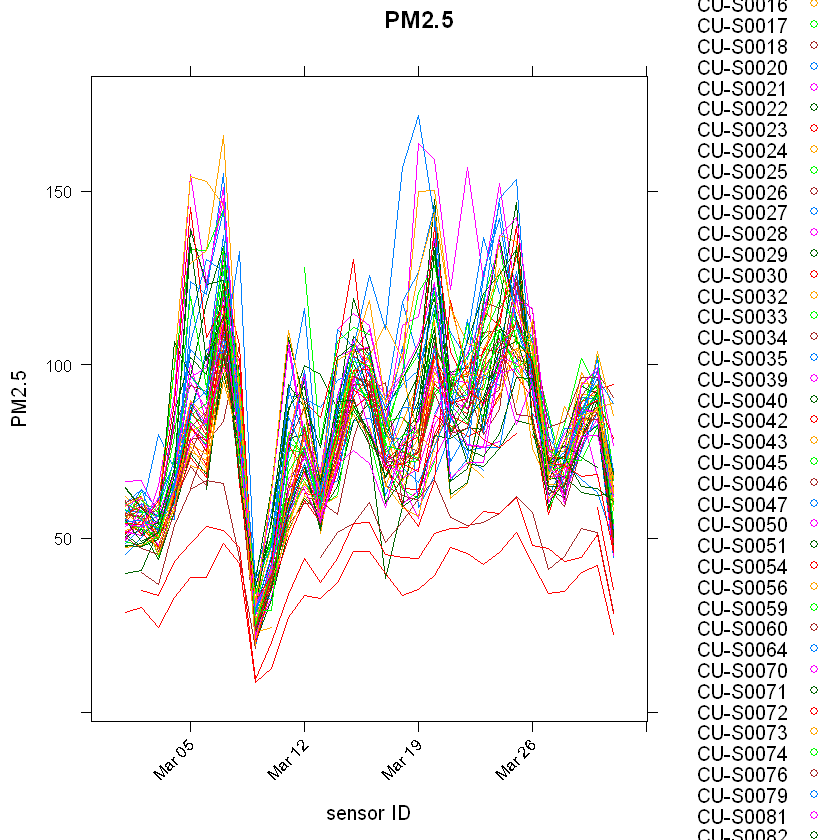

In [96]:
stplot(stdata,mode="xt",cuts=9,scales=scales,xlab="sensor ID",col.regions = colorsetting)
stplot(stdata,mode="ts",scales=scales,xlab="sensor ID",col.regions = colorsetting)

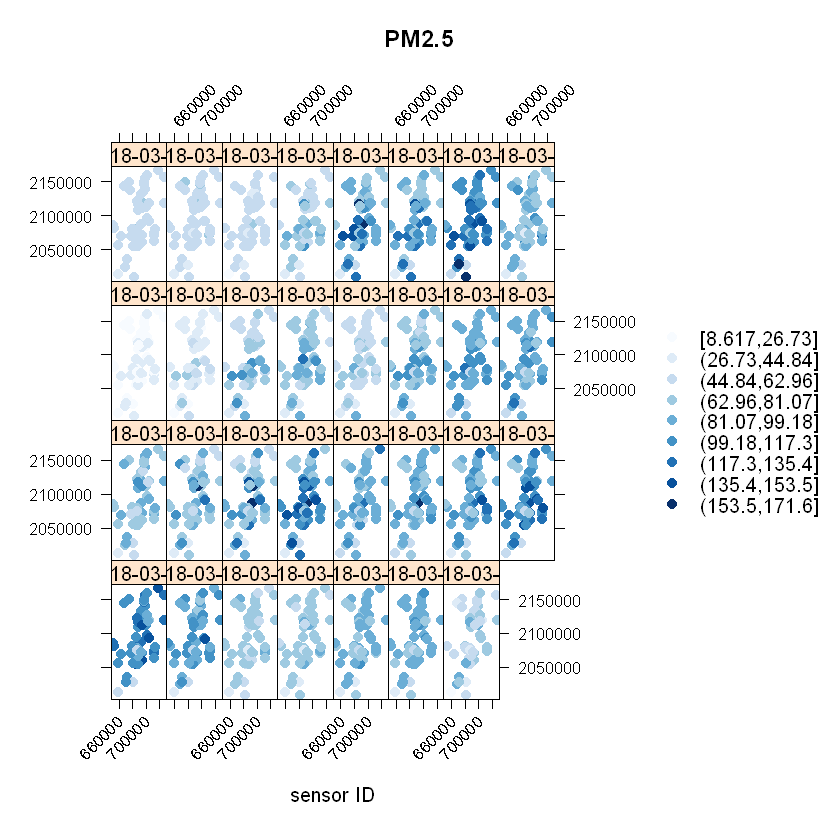

In [97]:
stplot(stdata,cuts=9,scales=scales,xlab="sensor ID",col.regions = colorsetting)

In [98]:
summary(stdata)

Object of class STFDF
 with Dimensions (s, t, attr): (61, 31, 1)
[[Spatial:]]
Object of class SpatialPoints
Coordinates:
          min       max
lon  651242.9  726957.9
lat 2008840.6 2166302.0
Is projected: TRUE 
proj4string :
[+init=epsg:32647 +proj=utm +zone=47 +datum=WGS84 +units=m +no_defs
+ellps=WGS84 +towgs84=0,0,0]
Number of points: 61
[[Temporal:]]
     Index                       timeIndex   
 Min.   :2018-03-01 00:00:00   Min.   : 1.0  
 1st Qu.:2018-03-08 12:00:00   1st Qu.: 8.5  
 Median :2018-03-16 00:00:00   Median :16.0  
 Mean   :2018-03-16 00:00:00   Mean   :16.0  
 3rd Qu.:2018-03-23 12:00:00   3rd Qu.:23.5  
 Max.   :2018-03-31 00:00:00   Max.   :31.0  
[[Data attributes:]]
     PM2.5        
 Min.   :  8.617  
 1st Qu.: 61.440  
 Median : 78.941  
 Mean   : 79.091  
 3rd Qu.: 95.585  
 Max.   :171.639  
 NA's   :127      

เลือกกลุ่มแรกๆมาจากที่แบ่ง k-mean ใน 2018 Analysis

In [99]:
rn <- c("CU-S0059","CU-S0064","CU-S0046","CU-S0081","CU-S0093","CU-S0072")

In [ ]:
#acf(na.omit(as(stdata,"xts")),lag=16)

In [100]:
library(gstat)
vv = variogram(PM2.5~1, stdata, width=2500, tlags=0:6)

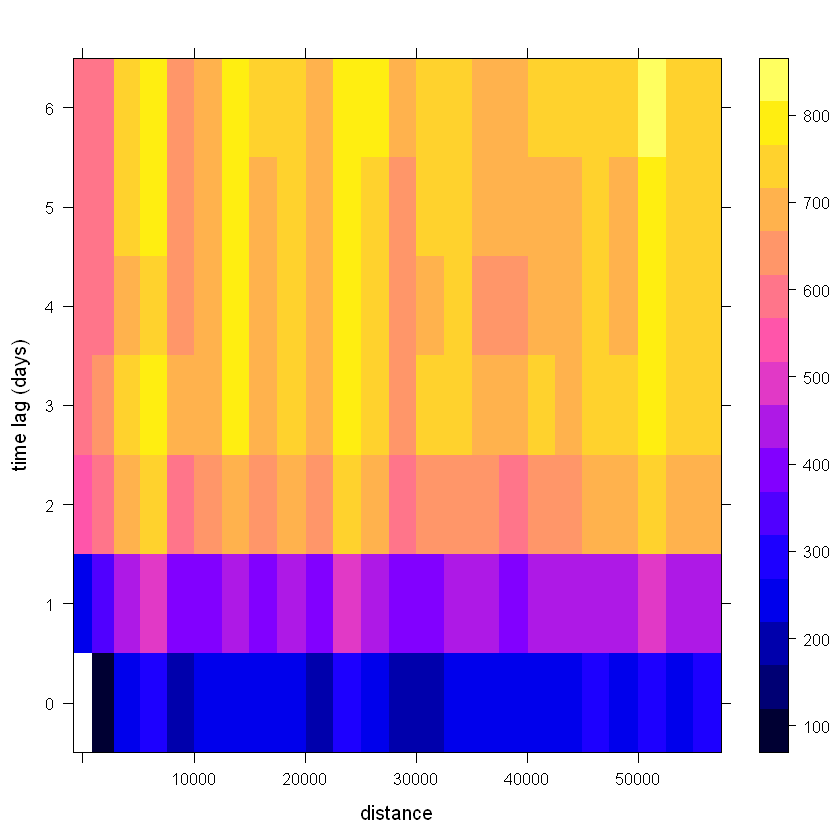

In [101]:
plot(vv)

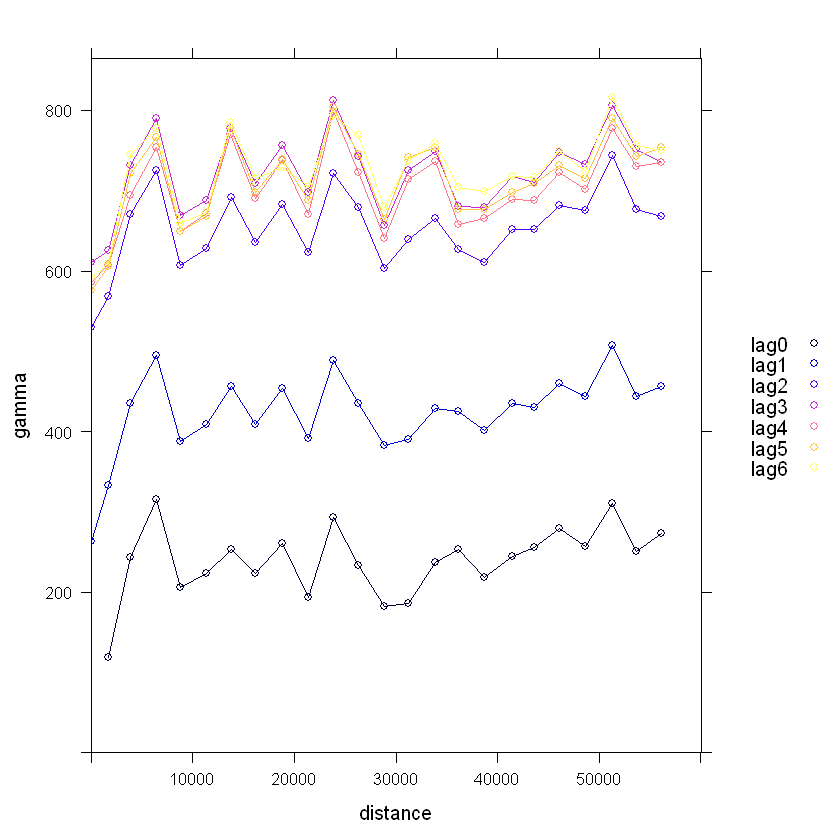

In [102]:
plot(vv, map = FALSE)

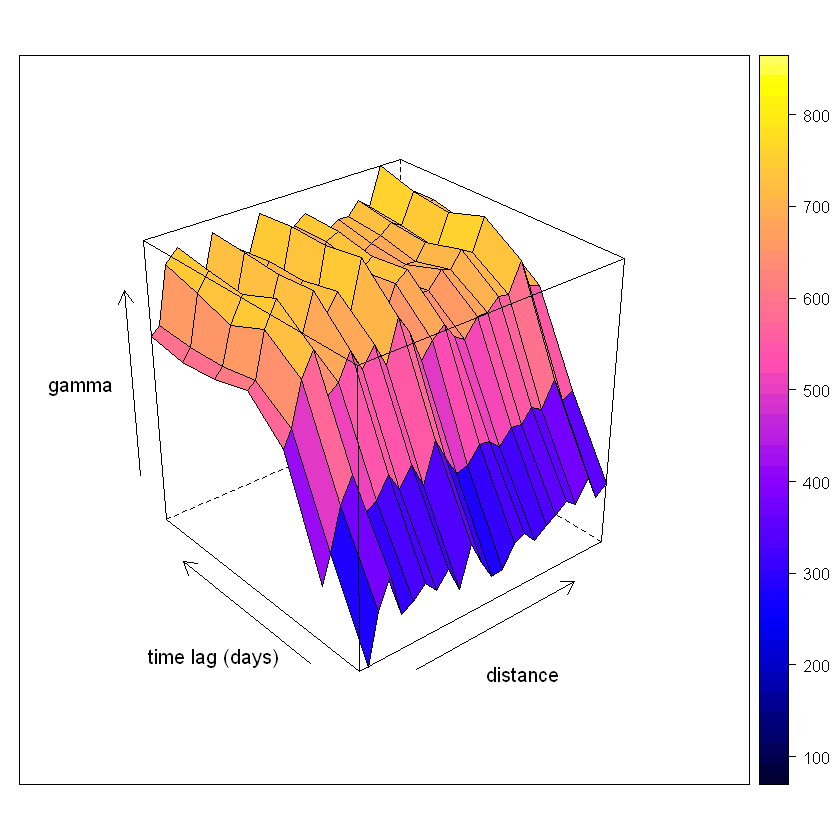

In [103]:
library(lattice)
plot(vv,all=T, wireframe=T)